In [1]:
# Install HermesPy and its dependencies in the current kernel
# When running on Colabs, a restart of the runtime is required afterwards

import sys
!{sys.executable} -m pip install --quiet hermespy

Implementing Precodings
========================

[Symbol Precoders](../api/modem.precoding.symbol_precoding.SymbolPrecoder.rst) are Hermes' abstraction for operations on time-domain series of complex numbers representing communication symbols.
Within the signal processing chain for communication, modeled by the [Modem](../api/modem.rst) module, [Symbols](../api/modem.symbols.rst) are considered in between the mapping of bit streams to symbols and their modulation to base-band signals during transmission, and, inversely, in between the demodulation of base-band signals to symbols and their following unmapping to bit streams.

At this stage, users may configure custom operations on the symbol series for any coherent modulation scheme.
This tutorial will demonstrate the programming interface by implementing a symbol precoding which only reverses the modulated symbols in time-domain.
We don't expect any performance gain or loss from this operation, the only purpose of this exercise is to get new users and developers accustomed to the specific interface.

Let's jump right into it and implement the prosed precoding as a class titled *SymbolFlipper*, which inherits from the base [Symbol Precoders](../api/modem.precoding.symbol_precoding.SymbolPrecoder.rst), common to all symbol precoding routines.

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from hermespy.modem import StatedSymbols, SymbolPrecoder


class SymbolFlipper(SymbolPrecoder):
    
    def encode(self, symbols: StatedSymbols) -> StatedSymbols:
        
        encoded_symbols = symbols.copy()
        encoded_symbols.raw = np.flip(encoded_symbols.raw, axis=1)
        
        return encoded_symbols
        
    def decode(self, symbols: StatedSymbols) -> StatedSymbols:
        
        decoded_symbols = symbols.copy()
        decoded_symbols.raw = np.flip(decoded_symbols.raw, axis=1)
        decoded_symbols.states = np.flip(decoded_symbols.states, axis=2)
        
        return decoded_symbols
    
    @property
    def num_input_streams(self) -> int:
        
        return self.required_num_input_streams
    
    @property
    def num_output_streams(self) -> int:
        
        return self.required_num_output_streams

[Symbol Precoders](../api/modem.precoding.symbol_precoding.SymbolPrecoder.rst) expect their two abstract methods [encode](../api/modem.precoding.symbol_precoding.SymbolPrecoder.rst#hermespy.modem.precoding.symbol_precoding.SymbolPrecoder.encode) and [decode](../api/modem.precoding.symbol_precoding.SymbolPrecoder.rst#hermespy.modem.precoding.symbol_precoding.SymbolPrecoder.decode) to be defined.
As their names already hint, the encode routine will be called during data transmission and perform an operation on an incoming stream of [StatedSymbols](../api/modem.symbols.rst#hermespy.modem.symbols.StatedSymbols), the decoding routine will be called during data reception and is expected to reverse the effects of its encoding counterpart.
Additionally, some precodings might alter the number of antenna streams during their coding operations, so two additional properties [num_input_streams](../api/precoding.precoding.rst#hermespy.precoding.precoding.Precoder.num_input_streams) and [num_output_streams](../api/precoding.precoding.rst#hermespy.precoding.precoding.Precoder.num_output_streams) must be specified.

[StatedSymbols](../api/modem.symbols.rst#hermespy.modem.symbols.StatedSymbols) are an extension of [Symbols](../api/modem.symbols.rst#hermespy.modem.symbols.StatedSymbols) and carry [ChannelStateInformation](../api/core.channel_state_information.rst) as additional information next to the raw symbol stream.
This is required since some symbol precodings might rely on a channel estimate for effective precoding.
Both the raw symbol stream and channel state information are essentially numpy arrays of specific dimensions.
The raw symbol array has three dimensions, representing antenna streams, words and symbols, respectively, while the channel state information has four dimensions, representing output antennas, input antennas, words and symbols, respectively.

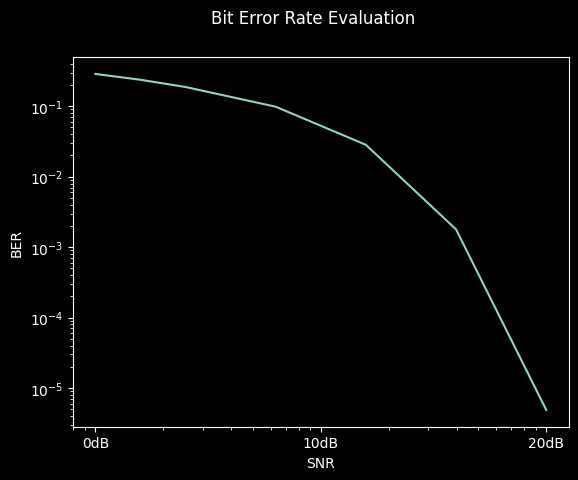

In [3]:
from hermespy.core import ConsoleMode, dB
from hermespy.simulation import Simulation
from hermespy.modem import BitErrorEvaluator, DuplexModem, ElementType, FrameElement, FrameResource, FrameSymbolSection, OFDMWaveform

# Create a new Monte Carlo simulation
simulation = Simulation(console_mode=ConsoleMode.SILENT)

# Add a single device, operated by a communication modem
operator = DuplexModem()
operator.device = simulation.new_device()

# Configure an OFDM waveform with a frame consisting of a single symbol section
operator.waveform = OFDMWaveform(resources=[FrameResource(elements=[FrameElement(ElementType.DATA, 1024)])],
                                           structure=[FrameSymbolSection(pattern=[0])])

# Configure our newly implemented symbol precoding
operator.precoding[0] = SymbolFlipper()

# Configure a parameter sweep over the receiver SNR, effectively simulating an AWGN channel
simulation.new_dimension('snr', dB(0, 2, 4, 8, 12, 16, 20))

# Evaluate the BER
simulation.add_evaluator(BitErrorEvaluator(operator, operator))

# Run the simulation and plot the results
result = simulation.run()

_ = result.plot()
plt.show()

To highlight that the implemented precoder has no effect on the communication performance, we can deactivate it and re-run the simulation:

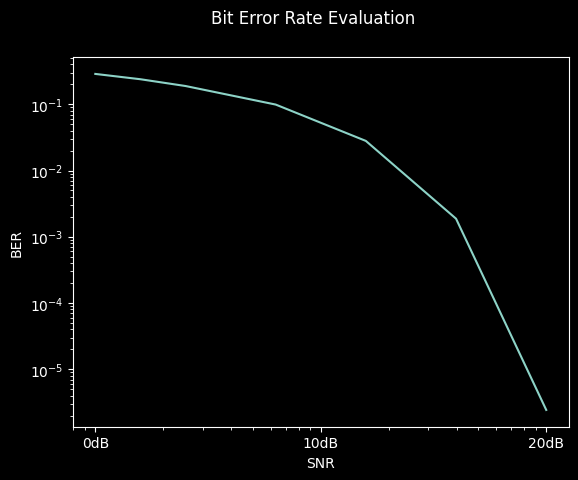

In [4]:
operator.precoding.pop_precoder(0)

result = simulation.run()

_ = result.plot()
plt.show()